# 팀 스마일C 코드 제출
* 팀원: 정우섭, 김유민, 김유진, 장동언, 황정묵
* PRIVATE SCORE: 0.65887 
* PRIVATE RANKING: 36

# 개발 환경
* OS : Windows11
* python: 3.10.10
* 라이브러리 버전 : requirements.txt 참조

# 0.Data Load
1. install packages
2. import libraries and csv data files

In [1]:
# !pip install catboost
# !pip install lightgbm
# !pip install optuna 
# !pip install xgboost
# !pip install torch

In [2]:
import pandas as pd
import random
import os
import numpy as np
import matplotlib.pyplot as plt   
import seaborn as sns 

# model evaluation, preprocessing 
import sklearn
from sklearn import preprocessing, metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_validate,GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_auc_score, log_loss

# sequential model modeling 
import tensorflow as tf
from tensorflow import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense,Dropout, Activation
from keras import backend as K 
from keras import regularizers
from keras.layers import Dense,Dropout, Activation, BatchNormalization, Conv2D, Flatten  
from keras import optimizers, metrics, callbacks
from keras.backend import clear_session

# optuna Hyper-params tuning
!pip install optuna
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate, plot_contour

# ML classification models 
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier,VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifierCV
from xgboost import XGBClassifier

# # Google Drive mount
# from google.colab import drive 
# drive.mount('/content/drive')

2023-03-26 14:05:04.443743: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-26 14:05:05.479464: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# seed fixing for reproduction 
import torch 
import random as rn 

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore
seed_everything(37)
seed_num=37
seed=37

np.random.seed(seed_num)
rn.seed(seed_num) 
tf.random.set_seed(seed_num)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(config=session_conf)
K.set_session(sess)

class config:   
    seed = 37  
    device = "cuda:0"            

def seed_everything(seed: int = 37):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
seed_everything(config.seed)
tf.random.set_seed(37) # tensorflow global seed 
print(config.seed)     

2023-03-26 14:05:12.002925: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-03-26 14:05:12.015520: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-03-26 14:05:12.016804: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

37


2023-03-26 14:05:12.785766: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-03-26 14:05:12.787319: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-03-26 14:05:12.788797: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
submit = pd.read_csv('sample_submission.csv')

train_x = train_df.drop(columns=['PRODUCT_ID', 'Y_Class','Y_Quality'])
train_y = train_df['Y_Class']
test_x = test_df.drop(columns=['PRODUCT_ID'])   

# 1.Data & Features

## 1.1 EDA
1. feature correlation heatmaps
2. feature importance
3. feature distribution plots

In [5]:
# random 20 features list (모두 NaN인 컬럼 제외하고, 랜덤 20개 feature의 상관관계 히트맵)
Xs = train_df.iloc[:,4:].columns
null_count = train_df.isnull().sum().to_dict()
cols = pd.DataFrame({i for i in null_count if null_count[i]<250 and i in Xs})
cols_name = list(cols[0])  # not_all_NAN features name in list 

import random
a = ['Y_Quality']
for i in range(20):
    num = random.randint(1,3326)
    a.append(cols_name[i])

# heatmap: `random X features` and `Y_Quality` correlation
corr = train_df[a].corr()  # correlation matrix
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='Blues', linewidths=2);

IndexError: list index out of range

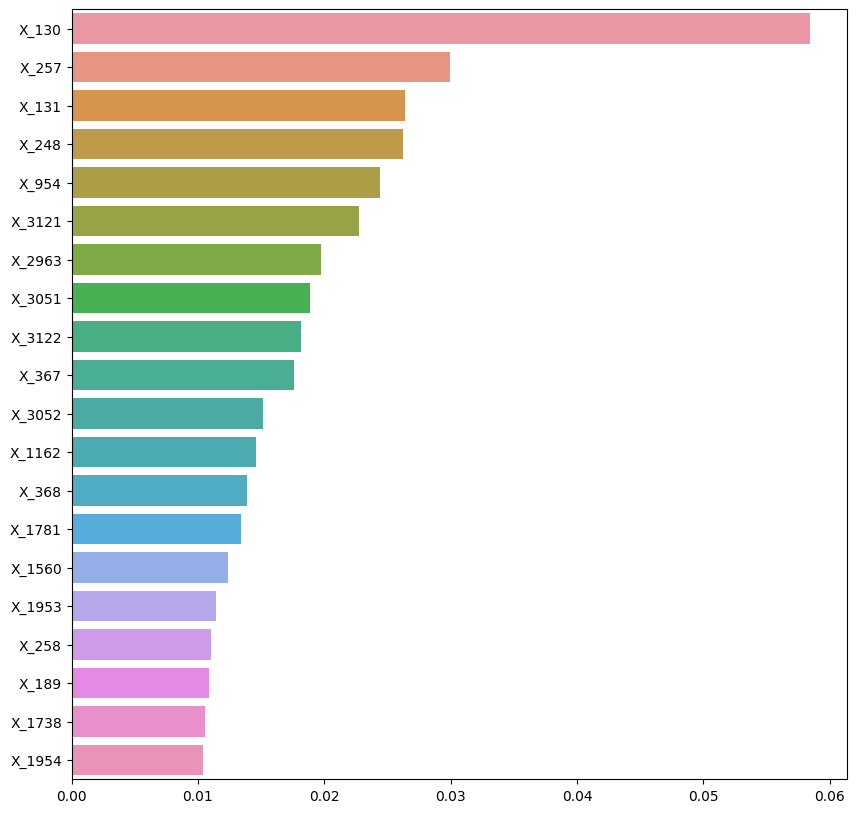

In [6]:
# feature 중요도
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

qual_col = ['LINE', 'PRODUCT_CODE']
for i in qual_col:
    le = LabelEncoder()
    le = le.fit(train_x[i])
    train_x[i] = le.transform(train_x[i])
    for label in np.unique(test_x[i]):
        if label not in le.classes_:
            le.classes_ = np.append(le.classes_, label)
    test_x[i] = le.transform(test_x[i])

train_x = train_x.fillna(0)
test_x = test_x.fillna(0)
X_train, X_test, y_train, y_test=train_test_split(train_x,train_y,test_size=0.3,random_state=seed_num)

%matplotlib inline
RF = RandomForestRegressor(random_state=0, max_depth=5, min_samples_leaf=8, min_samples_split=8,n_estimators=200)
RF.fit(X_train, y_train)
ftr_importances_values = RF.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top = ftr_importances.sort_values(ascending=False)[:20]
 
plt.figure(figsize=(10, 10))
sns.barplot(x=ftr_top, y=ftr_top.index)
plt.show()      

In [7]:
# feature distribution 
train_x.describe()    

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
count,1132.000000,1132.000000,1132.000000,1132.000000,1132.0,1132.000000,1132.000000,1132.0,1132.000000,1132.000000,...,1.132000e+03,1.132000e+03,1132.000000,1132.000000,1132.000000,1132.000000,1.132000e+03,1.132000e+03,1132.000000,1132.000000
mean,3.738516,1.473498,2.039753,70.292403,0.0,33.317138,7.651060,0.0,35.968198,7.423145,...,9.889046e-07,4.956272e-07,0.025731,0.000003,0.000131,0.000004,4.280830e-07,2.921926e-07,0.025489,0.000002
std,1.488714,0.877161,7.968506,41.810847,0.0,19.743025,4.552005,0.0,21.583200,4.401020,...,2.535108e-06,1.284767e-06,0.065117,0.000008,0.000348,0.000012,1.144174e-06,7.785554e-07,0.064508,0.000007
min,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,4.000000,2.000000,2.000000,93.000000,0.0,45.000000,10.000000,0.0,45.000000,10.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
75%,5.000000,2.000000,2.000000,96.000000,0.0,45.000000,10.000000,0.0,51.000000,10.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
max,5.000000,2.000000,154.000000,102.000000,0.0,46.000000,11.000000,0.0,67.000000,11.000000,...,1.030000e-05,7.070000e-06,0.193656,0.000035,0.001310,0.000048,6.510000e-06,3.410000e-06,0.193000,0.000033


<Axes: xlabel='X_376', ylabel='Count'>

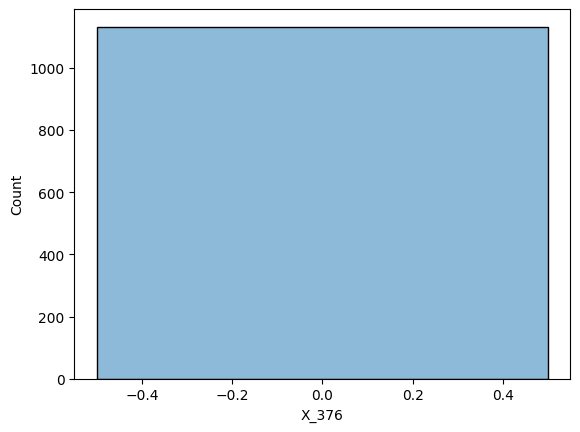

In [8]:
# feature histogram with KDE (밀도그래프) 
# 임의의 feature에 대한 histplot + 밀도 곡선 출력
num = random.randint(1,3326)
sns.histplot(train_x[f'X_{num}'], kde=True)

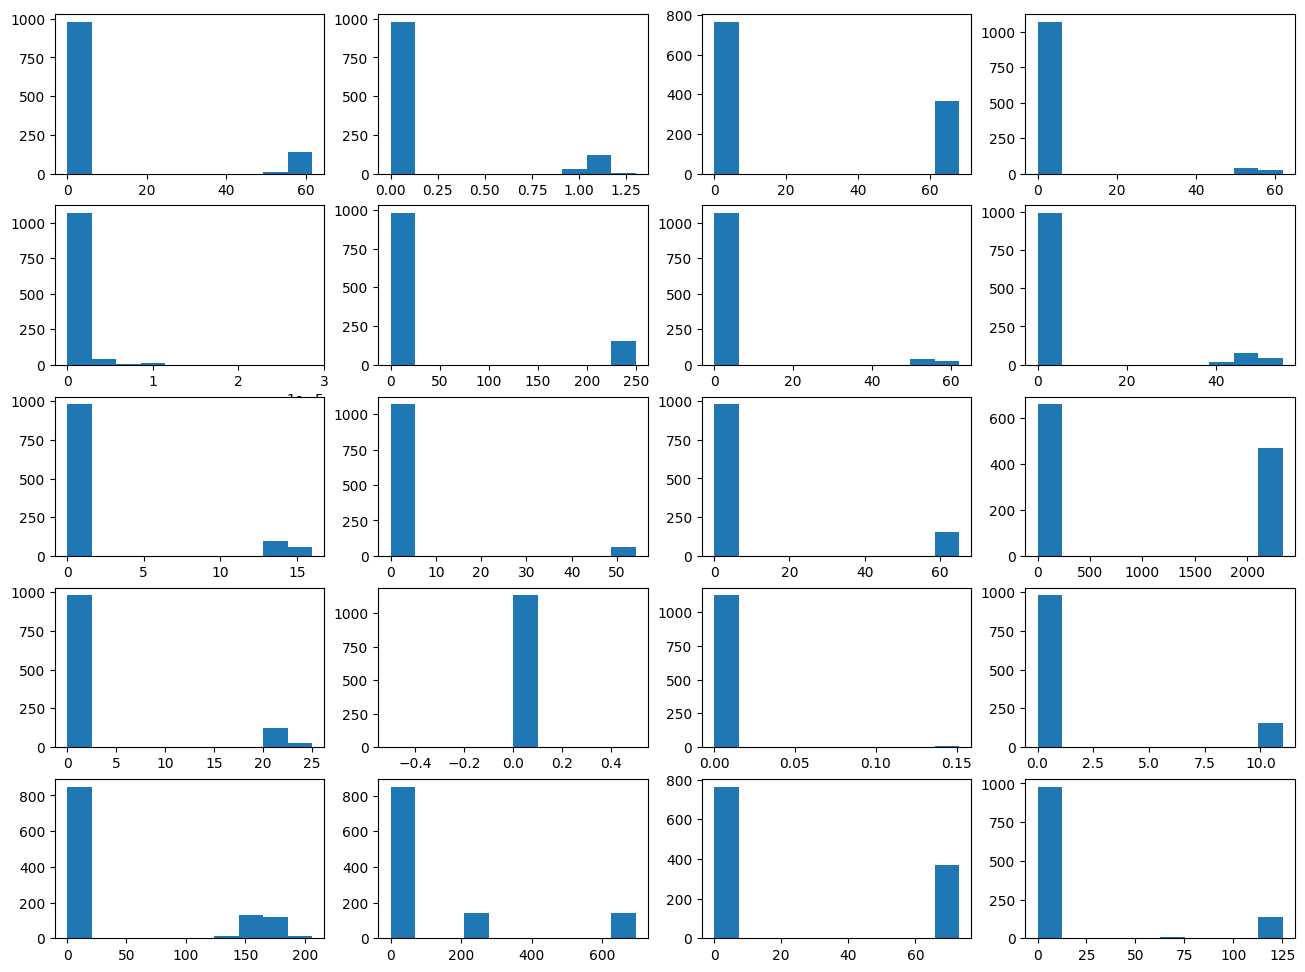

In [9]:
# visualize random 20 features distribution 
# imbalanced feature distribution (NO Gaussian distribution shape) --> MinMaxscaler
fig, axes = plt.subplots(5,4,figsize=(16,12))
ax= axes.flatten()

for i in range(20): 
    num = random.randint(1,3326)
    ax[i].hist(train_x[f'X_{num}']);    

## 1.2 Preprocessing
1. Label Encoding: categorical values `LINE`, `PRODUCT_CODE`
2. Missing values: fillna(0) 
3. scaling: StandardScaler

In [10]:
# 데이터 처리 - 예선

# train_df = pd.read_csv('./train.csv')
# test_df = pd.read_csv('./test.csv')
# submit = pd.read_csv('./sample_submission.csv')

# train_x = train_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP', 'Y_Class','Y_Quality'])
# train_y = train_df['Y_Class']
# test_x = test_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])   

In [11]:
# 데이터 처리 - 본선
# 1) qualitative to quantitative
qual_col = ['LINE', 'PRODUCT_CODE']
for i in qual_col:
    le = LabelEncoder()    # one-hot encoding (X): get_dummies(test_df) is not allowed (data leakage)   
    le = le.fit(train_x[i])
    train_x[i] = le.transform(train_x[i])
    for label in np.unique(test_x[i]): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test_x[i] = le.transform(test_x[i]) 


In [12]:
# train에서 열의 유일한 값이 nan이거나 모두 같은 값인 경우 해당 열을 제외
def remove_col(train_df):
    for x in train_x.columns[6:]:
        if train_x[x].nunique()==0 or len(train_x[x].unique())==1: # nan 이거나 모두 같은 값인 경우
            train_x.drop(columns=[x], inplace=True) 
            test_x.drop(columns=[x], inplace=True)       
    return train_df

train = remove_col(train_df) 

In [13]:
# 2) Missing Values - fillna(0) - 더 나은 방법 존재.
# train_x = train_x.fillna(0)
# test_x = test_x.fillna(0)

# 3) MinMaxscaling: only `X_???` values (continuous)
# Xs = train_x.select_dtypes(include=float).iloc[:,1:].columns.tolist()
# scaler = MinMaxScaler().fit(train_x.loc[:, Xs])
# train_x.loc[:, Xs] = scaler.transform(train_x.loc[:, Xs])
# test_x.loc[:, Xs] = scaler.transform(test_x.loc[:, Xs])

In [14]:
# KNN Imputer 
from sklearn.impute import KNNImputer

# Impute missing values using KNN imputer on train data
imputer = KNNImputer(n_neighbors=5)   # n_neighbors: params
imputer.fit(train_x)
                                 
train_x = imputer.transform(train_x)    
test_x = imputer.transform(test_x) 
train_x = pd.DataFrame(train_x)
test_x = pd.DataFrame(test_x)
train_x.head()

X_train, X_test, y_train, y_test=train_test_split(train_x,train_y,test_size=0.3,random_state=seed_num)

In [15]:
print(train_x.shape)

(1132, 3035)


# 2.Modeling

## 2.1 ML models
- 여러 Machine Learning Classifier 모델들의 test set Accuracy score 도출 
    - Ensemble에서 각 모델의 weight(가중치) 정하기 위한 근거로 사용하기 위함
1. RandomForestClassifier
2. GradientboostingClassiifer
3. XGBClassifier
4. LGBMClassifier
5. CatboostClassifier
6. RidgeClassifier
7. BaggingClassifier

In [16]:
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

models = [
    RandomForestClassifier(random_state=seed_num), 
    GradientBoostingClassifier(random_state=seed_num),      
    XGBClassifier(random_state=seed_num),
    LGBMClassifier(objective='multiclass', random_state=seed_num),
    CatBoostClassifier(objective='MultiClass',
                                   task_type='GPU',
                                   one_hot_max_size=2, random_seed=seed_num,
                                   iterations=4000, verbose=False,
                                   learning_rate=0.05
                                   ),
    RidgeClassifierCV(),  # RidgeClassifier: no seed setting argument  
    BaggingClassifier(random_state=seed_num)]

In [17]:
# find weights for each model 
model_list = ['RF', 'GBC', 'XGB', 'LGBM', 'Catboost', 'Ridge', 'Bagging']
i=0
model_acc = {}

for model in models:  
    if i == 4: 
        preds = model.fit(X_train, y_train).predict(X_test)
        preds = preds.reshape(1,340)
        preds = list(preds[0])
    else: 
        preds = model.fit(X_train, y_train).predict(X_test)

    globals()[f'preds_{model_list[i]}'] = preds   # set variable name for each model prediction results  
  
    score = sklearn.metrics.accuracy_score(y_test, preds)
    model_acc[model_list[i]] = score
    i += 1   

print(model_acc)   

{'RF': 0.7411764705882353, 'GBC': 0.7647058823529411, 'XGB': 0.7558823529411764, 'LGBM': 0.7705882352941177, 'Catboost': 0.7617647058823529, 'Ridge': 0.27647058823529413, 'Bagging': 0.7411764705882353}


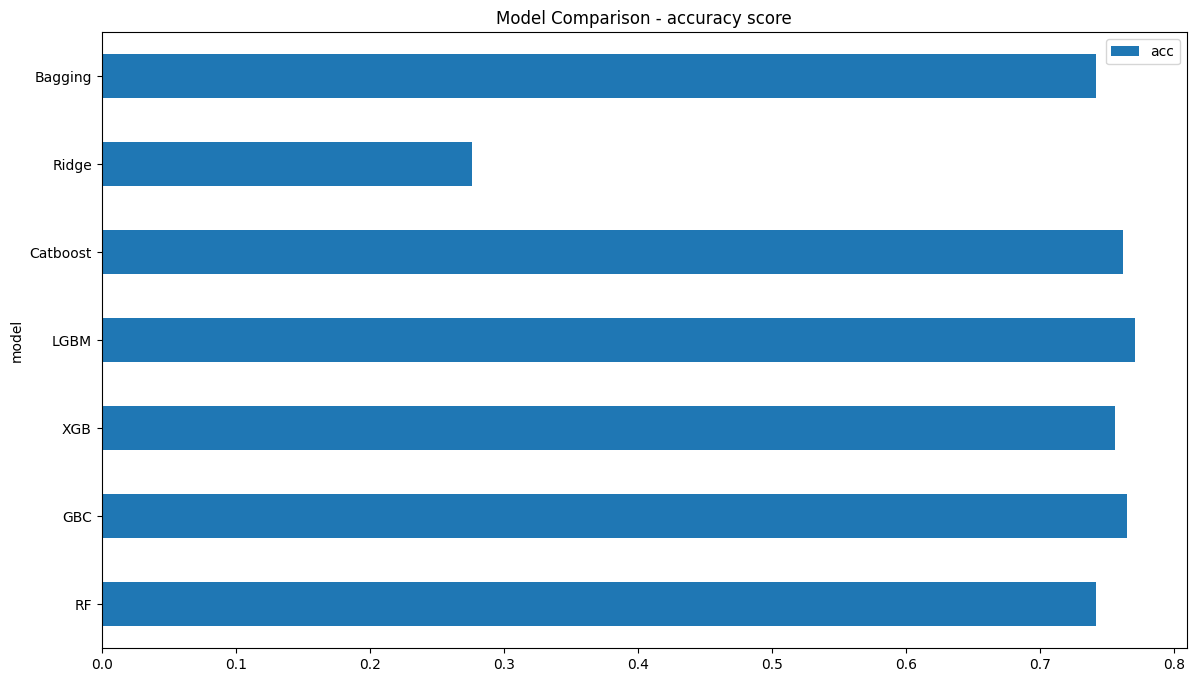

In [18]:
# ML models accuracy comparison plot 
model_name = list(model_acc.keys())
model_acc = list(model_acc.values())
acc_dic = {'model': model_name, 'acc': model_acc}
acc_df = pd.DataFrame(acc_dic)
acc_df = acc_df.set_index('model')

acc_df.plot(kind='barh', figsize=(14,8),
            title='Model Comparison - accuracy score');

## 2.2 Sequential MLP 
* Deep Learning Modeling: Sequential MLP model

In [19]:
import torch.nn as nn 
import torch.nn.functional as F 

class MultilayerPerceptron(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        """
        parameters: 
            input_dim (int): 입력 벡터 크기
            hidden_dim1 (int): 첫 번째 Linear 층의 출력 크기
            hidden_dim2 (int): 두 번째 Linear 층의 출력 크기 
            output_dim (int): 세 번째 Linear 층의 출력 크기 
        """
        super(MultilayerPerceptron, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
       # self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.fc4 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x_in, apply_softmax=False):
        """
        MLP의 정방향 계산 

        parameters:
            x_in (torch.Tensor): 입력 데이터 텐서
                x_in.shape는 (batch, input_dim)
            apply_softmax (multiclasses): softmax activation function 
        return: 
            result Tensor
            tesnor.shape: (batch, output_dim)
        """
        intermediate1 = F.relu(self.fc1(x_in))   # activation function
        intermediate2 = F.relu(self.fc2(intermediate1))   # activation function
       # intermediate3 = F.relu(self.fc3(intermediate2))   # activation function
        output = self.fc4(intermediate2)    


        if apply_softmax: 
            output = F.softmax(output, dim=1)   # output layer: softmax activation function
        return output 

In [20]:
def describe(x): 
    print(f'Type: {x.type()}')
    print(f'shape: {x.shape}')
    # print(f'value: {x}') 

#2차원 데이터이므로 복잡하지 않게 은닉층 2개 사용.

batch_size = 256 
input_dim = train_x.shape[-1]
hidden_dim1 = 1024
hidden_dim2 = 512
output_dim = 3 

# model design 
mlp = MultilayerPerceptron(input_dim, hidden_dim1, hidden_dim2, output_dim)
print(mlp)
x_input = torch.rand(batch_size, input_dim)
y_output = mlp(x_input, apply_softmax=True)  # result: probabilities format 
a = y_output
describe(y_output)

MultilayerPerceptron(
  (fc1): Linear(in_features=3035, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=3, bias=True)
)
Type: torch.FloatTensor
shape: torch.Size([256, 3])


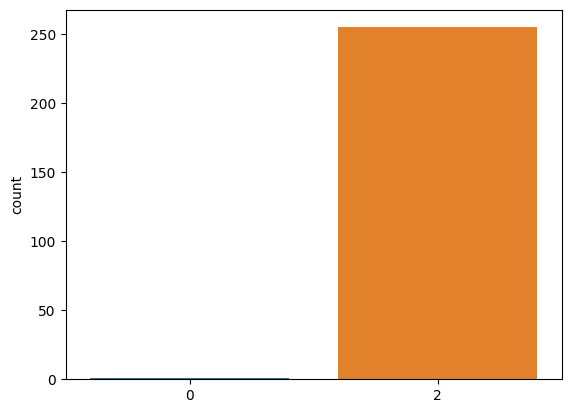

In [21]:
prediction=[]

for i in a: 
    i = list(i)
    prediction.append(i.index(max(i)))

sns.countplot(x=prediction);    

# 3.Params Optimization

사용하고자 했던 전략
1. GridSearch
2. Optuna

## 3.1 Light Gradient Boosting
1. Optuna
    - hyperparameters auto optimization

In [22]:
# def objective(trial, X, y, cv, scoring):
#     params = {
#         'lambda_l1' : trial.suggest_loguniform('lambda_l1', 1e-8, 1e-1),
#         'lambda_l2' : trial.suggest_loguniform('lambda_l2', 1e-8, 1e-1),
#         'path_smooth' : trial.suggest_loguniform('path_smooth', 1e-8, 1e-3),
#         'num_leaves' : trial.suggest_int('num_leaves', 30, 200),
#         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
#         'max_bin' : trial.suggest_int('max_bin', 100, 255),
#         'feature_fraction' : trial.suggest_uniform('feature_fraction', 0.5, 0.9),
#         'bagging_fraction' : trial.suggest_uniform('bagging_fraction', 0.5, 0.9),
#     }
#   # Perform cross validation
#   # gb_class = GradientBoostingClassifier(**params)
#     lgbm_class = LGBMClassifier(**params)

#   # Compute scores
#     scores = cross_validate(lgbm_class, X, y, cv = cv, scoring = scoring, n_jobs = -1)
#     accuracy = scores["test_score"].mean()
#     return accuracy

- Optimization for params

    - K-Fold, trials = 10

In [23]:
# sampler = optuna.samplers.TPESampler(seed=10, gpu_properties={'device_id': 0})
# study = optuna.create_study(direction = "maximize")
# study.set_user_attr("verbose", True)

# kf = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=37)

# func = lambda trial: objective(trial, X_train, y_train, cv = kf, scoring = "accuracy")

# # # %%time
# # # Start optimizing with 100 trials
# study.optimize(func, n_trials = 10,n_jobs=-1)

# print(f"The highest accuracy reached by this study: {(study.best_value) * 100}%.")
# print("Best params:")
# for key, value in study.best_params.items():
#     print(f"\t{key}: {value}")    

In [24]:
import imblearn

#위의 Optuna 방법을 통해 알아낸 hyper Parameter 고정.
#best_value로 정하지만 계속 훈련시키기엔 시간이 오래걸려 고정

params= {'lambda_l1': 0.00048021471491299205,'lambda_l2': 0.021386150387940235,
         'path_smooth': 4.976692465226837e-07,'num_leaves': 83,
         'min_data_in_leaf': 16,'max_bin': 219,
         'feature_fraction': 0.6536282159518209,'bagging_fraction': 0.7302696718518357,}

LGBM =  LGBMClassifier(random_state=37, **params,).fit(X_train, y_train)
lgbm_preds = LGBM.predict(X_test)

print(classification_report(y_test, lgbm_preds))
print("\n LGBM acc(Optuna) : ", accuracy_score(y_test, lgbm_preds))

[LightGBM] [Warning] feature_fraction is set=0.6536282159518209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6536282159518209
[LightGBM] [Warning] bagging_fraction is set=0.7302696718518357, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7302696718518357
[LightGBM] [Warning] lambda_l1 is set=0.00048021471491299205, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00048021471491299205
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] lambda_l2 is set=0.021386150387940235, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.021386150387940235
              precision    recall  f1-score   support

           0       0.79      0.36      0.49        53
           1       0.76      0.95      0.84       227
           2       0.74      0.42      0.53        60

    accuracy                           0.76       340
   macro avg       0.76   

In [25]:
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_contour

In [26]:
# RandomForest Classifier의 하이퍼 파라미터를 Grid Search를 통해 찾아낸 후 고정.
#
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [10, 20, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt'],
#     'bootstrap': [True, False],
#     'random_state': [42]
# }

# # 랜덤 포레스트 분류기 생성
# RFCC = RandomForestClassifier()

# # 그리드 서치 객체 생성
# rf_grid_search = GridSearchCV(
#     estimator=RFCC,
#     param_grid=param_grid,
#     cv=5,
#     n_jobs=-1,
#     verbose=2
# )

# # 그리드 서치 수행
# rf_grid_search.fit(X_train, y_train)

# # 최적의 하이퍼 파라미터 출력
# print('Best parameters:', rf_grid_search.best_params_)

## 3.2 Random Forest
1. Grid Search
    - Search from Scale

In [28]:
RF=RandomForestClassifier(bootstrap=False, criterion='entropy', 
                          max_depth=None, max_features='sqrt', 
                          min_samples_leaf=4, min_samples_split=10, 
                          n_estimators=300, random_state=42).fit(X_train,y_train)
rf_preds=RF.predict(X_test)
print("RF acc(Grid Search): ",accuracy_score(y_test, rf_preds))

# Optuna로 얻은 RandomForest Classifier의 하이퍼파라미터
# max_depth= int(17.53243068297166), n_estimators=10,random_state=seed_num

RF acc(Grid Search):  0.7470588235294118


In [29]:
#Optuna로 RandomForest Classifier 하이퍼 파라미터 튜닝.

# from sklearn.model_selection import cross_val_score
# # Change following line to range(NFOLDS) to run & find best params.
# # for fold_id in range(5, 5):
# #     print('========== Processing fold', fold_id, '==========')

# import optuna

# # 1. 최소화/최대화할 목적함수 정의
# def objective(trial):

# # 2. trial object로 하이퍼파라미터 값 추천
# # 다양한 분류모델을 설정해서 비교할 수 있다.
#     classifier_name = trial.suggest_categorical('classifier', ['RandomForest'])
#     # #분류 모델이 SVC일 때
#     # if classifier_name == 'SVC':
#     #     svc_c = trial.suggest_loguniform('svc_c', 1e-10, 1e10)
#     #     classifier_obj = sklearn.svm.SVC(C=svc_c, gamma='auto')
    
#     #분류모델이 랜덤포레스트일 때
#     # else:
#     # rf_max_depth = int(trial.suggest_loguniform('rf_max_depth', 2, 32))
#     # tfidf__analyzer = trial.suggest_categorical('tfidf__analyzer', ['word', 'char', 'char_wb']) 
#     # tfidf__lowercase = trial.suggest_categorical('tfidf__lowercase', [False, True]) 
#     tfidf__max_features = trial.suggest_int('tfidf__max_features', 500, 10_000) 
#     rf__n_estimators = trial.suggest_int('rf__num_estimators', 300, 500) 
#     rf__max_depth = trial.suggest_int('rf__max_depth', 5, 15) 
#     rf__min_samples_split = trial.suggest_int('rf__min_samples_split', 10, 30) 
    

#     classifier_obj = sklearn.ensemble.RandomForestClassifier(max_depth=rf__max_depth, 
#                                                              n_estimators=rf__n_estimators,
#                                                              max_features=tfidf__max_features,
#                                                              min_samples_split = rf__min_samples_split)
    
#     accuracy = cross_val_score(classifier_obj, train_x, train_y, cv = 5).mean()
#     return accuracy
    
# # 3. study 오브젝트 생성하고 목적함수 최적화하는 단계
# # 여기서는 목적함수를 정확도로 설정했기 때문에 최대화를 목표로 하고 있지만, 손실함수의 경우 direction='minimize'로 설정
# study = optuna.create_study(direction='maximize')
# # 반복 시행 횟수(trial)는 200번으로
# study.optimize(objective, n_trials=200)

# # Trial 42 finished with value: 0.7667966161163308 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 17.53243068297166}. 

In [30]:
# import joblib 
# from sklearn.pipeline import Pipeline

# model = Pipeline([('rf', RandomForestClassifier)])
# def objective(trial):    
    
#     joblib.dump(study, 'study.pkl')
    
#     tfidf__analyzer = trial.suggest_categorical('tfidf__analyzer', ['word', 'char', 'char_wb']) 
#     tfidf__lowercase = trial.suggest_categorical('tfidf__lowercase', [False, True]) 
#     tfidf__max_features = trial.suggest_int('tfidf__max_features', 500, 10_000) 
#     rf__n_estimators = trial.suggest_int('rf__num_estimators', 300, 500) 
#     rf__max_depth = trial.suggest_int('rf__max_depth', 5, 15) 
#     rf__min_samples_split = trial.suggest_int('rf__min_samples_split', 10, 30) 
    
   
    

#     params = {
#         'tfidf__analyzer': tfidf__analyzer,
#         'tfidf__lowercase': tfidf__lowercase,
#         'tfidf__max_features': tfidf__max_features,
#         'rf__n_estimators': rf__n_estimators,
#         'rf__max_depth': rf__max_depth,
#         'rf__min_samples_split': rf__min_samples_split,
       
#     }
    
#     model.set_params(**params)   

#     return  -np.mean(cross_val_score(model, X, y, cv=3, n_jobs=-1,scoring='neg_log_loss'))

# # by default, the direction is to minimizae, but can set it to maximize too
# #study = optuna.create_study(direction='minimize')
# study = optuna.create_study()


# #study.optimize(objective, timeout=3600)
# study.optimize(objective, n_trials=20)


# # to record the value for the last time
# joblib.dump(study, 'study.pkl')

## 3.3 CatBoost
1. optuna 
    - hyperparameters auto optimization
    - 시간 issue로 실패

In [31]:
# CBC = CatBoostClassifier(task_type='GPU', border_count=None)
# params_grid = {'iterations': [600, 700, 800, 900, 1000],
#                'depth': [4, 5, 6],
#                'loss_function': ['MultiClass'],
#                'l2_leaf_reg': np.logspace(-20, -19, 3),
#                'leaf_estimation_iterations': [10],
#                'eval_metric': ['Accuracy'],
#                'logging_level':['Silent'],
#                'random_seed': [42]}


In [32]:
# from sklearn.model_selection import GridSearchCV

# estimator = GradientBoostingClassifier(random_state = 37)

# param_grid = {
#             'n_estimators' : [n_estimators for n_estimators in range(100, 5000, 100)],
#             'learning_rate' : [lr * 0.0001 for lr in range(1, 10)],
#             'max_depth' : [depth for depth in range(3, 9)],
#             'subsample' : [subsample * 0.1 for subsample in range(5, 9, 1)],
#             'max_features' : ['auto', 'sqrt', 'log2']
#             }

# # scoring = 'r2' -> 결정계수로 scoring
# grid_GBC = GridSearchCV(estimator, param_grid, scoring = 'r2', n_jobs = -1)
# grid_GBC.fit(train_x, train_y)

# print('best estimator model: \n{}'.format(grid_GBC.best_estimator_))
# print('\nbest parameter: \n{}'.format(grid_GBC.best_params_))
# print("\nbest score: \n{}".format(grid_GBC.best_score_.round(3)))

In [33]:
# # GridSearch best parameter 
# import imblearn

# params= {'n_estimators': 1200, 'learning_rate': 0.009147154102399788, \
#         'max_depth': 9, 'subsample': 0.8, 'max_features': 'auto'}
# GBC =  GradientBoostingClassifier(random_state=37, **params,                              
#                                   ).fit(X_train, y_train)
# preds = GBC.predict(X_test)

# print(classification_report(y_test, preds))
# print("\n Grid : ", accuracy_score(y_test, preds))

In [34]:
# def objective(trial):
#     params = {
#         "iterations": 1000,
#         "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
#         "depth": trial.suggest_int("depth", 1, 10),
#         "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-8, 10),
#         "random_seed": 42,
#         "eval_metric": "Accuracy",
#         "od_type": "Iter",
#         "od_wait": 100,
#         "verbose": 1
#     }    


#     # iterations=trial.suggest_int("iterations", 100, 1000),
#     #     learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
#     #     depth=trial.suggest_int("depth", 4, 10),
#     #     l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
#     #     bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
#     #     random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
#     #     bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
#     #     od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
#     #     od_wait=trial.suggest_int("od_wait", 10, 50),
#     #     verbose=False
#     model=CatBoostClassifier(**params)
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     return f1_score(y_test, y_pred, average='macro')
     
# # # hyper-parameter tuning with OPTUNA  
# optuna.logging.set_verbosity(optuna.logging.WARNING)

# sampler = TPESampler(seed=37)
# study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
# study.set_user_attr("verbose", 1)
# study.optimize(objective, n_trials=0,n_jobs=-1)  

In [35]:
# print("Number of trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ",trial.params)

# CBC_model = CatBoostClassifier(**trial.params, verbose=False, random_state = 37)
# CBC_model.fit(X_train, y_train,verbose=1)
# y_pred = model.predict(X_test)


In [36]:
# CatBoost Classifier 하이퍼 파라미터 고정

params=  {'iterations': 857, 'learning_rate': 0.07097207730593516, 'depth': 8, \
        'l2_leaf_reg': 0.00012090525126196811, 'bootstrap_type': 'Bayesian', \
        'random_strength': 5.359110894800412, 'bagging_temperature': 0.7137022569955509, \
        'od_type': 'IncToDec', 'od_wait': 42}
CBC = CatBoostClassifier(**params, verbose=0, random_state=37, task_type='GPU')
CBC.fit(X_train, y_train)
preds_CBC = CBC.predict(X_test)

print(classification_report(y_test, preds_CBC))
print("\n Optuna : ", accuracy_score(y_test, preds_CBC))

              precision    recall  f1-score   support

           0       0.81      0.32      0.46        53
           1       0.75      0.97      0.84       227
           2       0.84      0.35      0.49        60

    accuracy                           0.76       340
   macro avg       0.80      0.55      0.60       340
weighted avg       0.77      0.76      0.72       340


 Optuna :  0.7588235294117647


In [37]:
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_contour

### 3.2.1 GridSearch

- hyperparameter optimization

# 4.Ensemble

## 4.1 Ensemble
     1. 3-ensemble Modle
     2. Cross-Validation 구축 후 성능 검증

In [38]:
# models에 학습시킨 모델들을 집어넣고 다시 학습.

models=[CBC,RF,LGBM] 
fit= [x.fit(train_x, train_y) for x in models]

[LightGBM] [Warning] feature_fraction is set=0.6536282159518209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6536282159518209
[LightGBM] [Warning] bagging_fraction is set=0.7302696718518357, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7302696718518357
[LightGBM] [Warning] lambda_l1 is set=0.00048021471491299205, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00048021471491299205
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] lambda_l2 is set=0.021386150387940235, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.021386150387940235


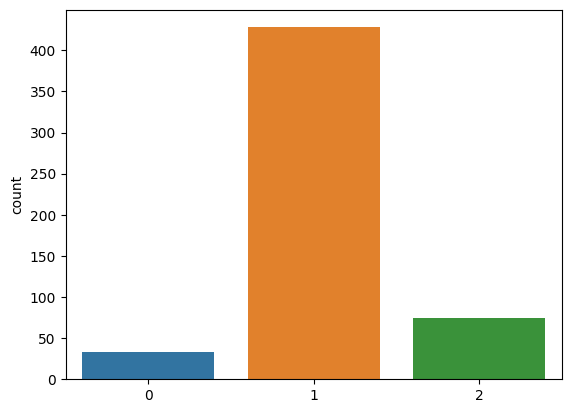

In [39]:
#prediction함수 생성하여 앙상블 - voting 방법 선택
def prediction(models, test, mode=None, weights=None):
    #hard voting일 경우
    if mode == "hard":
        preds = np.asarray([x.predict(test).reshape(-1) for x in models]).T
        res = np.apply_along_axis(
            lambda x: np.argmax(np.bincount(x, weights=weights)),
            axis=1,
            arr=preds
        )  
    #soft voting일 경우
    elif mode == "soft":  
        preds = np.asarray([x.predict_proba(test) for x in models])
        res = np.zeros(preds[0].shape)
        for pred, weight in zip(preds, weights):
            res = res + pred*weight
        res = np.argmax(preds, axis=0) 
    else:
        res = models[0].predict(test)
    return res

#hard voting을 선택하여 모델 중요도별 가중치 제공.
preds = prediction(models, test_x, 'hard', [2,5,4] )

sns.countplot(x=preds);   

## 4.2 Validation Score
1. train.csv에서 split된 test set accuracy 100% 검증

In [45]:
voting_model = sklearn.ensemble.VotingClassifier(estimators=[
                ('CatBoostClassifier', CBC),
                ('RandomForest', RF),
                ('LGBM', LGBM)], 
                voting='hard', weights=[2,5,4])

voting_model.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.6536282159518209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6536282159518209
[LightGBM] [Warning] bagging_fraction is set=0.7302696718518357, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7302696718518357
[LightGBM] [Warning] lambda_l1 is set=0.00048021471491299205, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00048021471491299205
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] lambda_l2 is set=0.021386150387940235, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.021386150387940235


VotingClassifier(estimators=[('CatBoostClassifier',
                              <catboost.core.CatBoostClassifier object at 0x7f9d7021a130>),
                             ('RandomForest',
                              RandomForestClassifier(bootstrap=False,
                                                     criterion='entropy',
                                                     min_samples_leaf=4,
                                                     min_samples_split=10,
                                                     n_estimators=300,
                                                     random_state=42)),
                             ('LGBM',
                              LGBMClassifier(bagging_fraction=0.7302696718518357,
                                             feature_fraction=0.6536282159518209,
                                             lambda_l1=0.00048021471491299205,
                                             lambda_l2=0.021386150387940235,
                                             max_bin=219, min_data_in_leaf=16,
                                             num_leaves=83,
                                             path_smooth=4.976692465226837e-07,
                                             random_state=37))],
                 weights=[2, 5, 4])

In [46]:
val_preds = voting_model.predict(X_test)  # 수정된 부분
val_score = sklearn.metrics.accuracy_score(y_test, val_preds)


# val_preds = prediction(voting_model, X_test, 'hard', [2,5,4])
# val_score= sklearn.metrics.accuracy_score(y_test, val_preds)
print("validation acc: ",val_score)

/usr/local/lib/python3.8/site-packages/sklearn/ensemble/_voting.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray([est.predict(X) for est in self.estimators_]).T


ValueError: could not broadcast input array from shape (340,1) into shape (340,)

# 5.Submit

In [50]:
submit = pd.read_csv('sample_submission.csv')
submit['Y_Class'] = preds

submit.to_csv('DACON_Submission.csv', index=False)
pd.DataFrame(preds).value_counts()

1    428
2     74
0     33
dtype: int64

# 6.References
PPT에 기재하였습니다


# THE END